In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
from scipy.stats import linregress, pearsonr
import pandas as pd
from collections import defaultdict
import random

np.random.seed(42)

## Task0

#### Ex. 1

In [2]:
# https://snap.stanford.edu/data/

file_path = "input/facebook_combined.txt"

G = nx.Graph()

with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        u, v = parts
        u, v = int(u), int(v)
        G.add_edge(u, v)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print("First 5 edges with weights:")
for u, v, data in list(G.edges(data=True))[:5]:
    print(u, v)

Number of nodes: 4039
Number of edges: 88234
First 5 edges with weights:
0 1
0 2
0 3
0 4
0 5


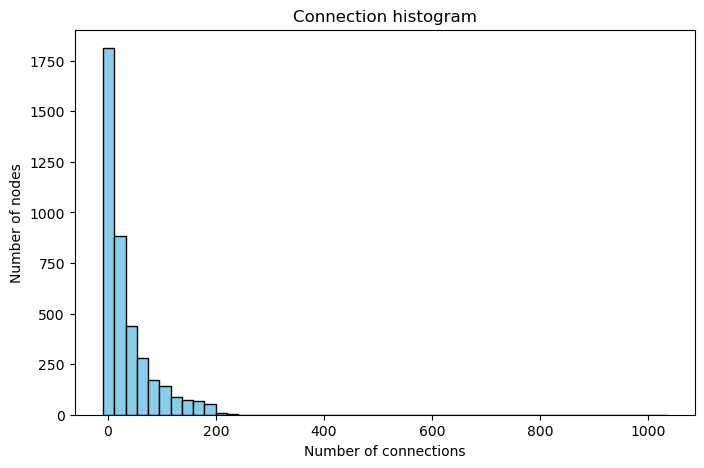

In [3]:
# drawing histogram
degrees = [val for (node, val) in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black", align="left")
plt.xlabel("Number of connections")
plt.ylabel("Number of nodes")
plt.title("Connection histogram")
plt.show()

#### Ex. 2

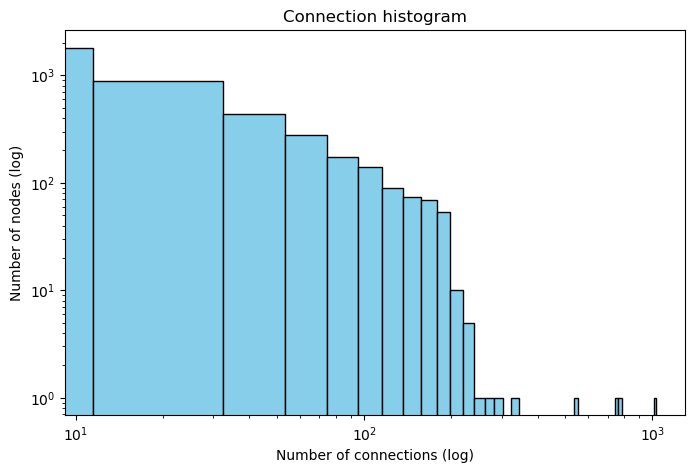

In [4]:
# drawing histogram on double log scale
degrees = [val for (node, val) in G.degree()]

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=50, color="skyblue", edgecolor="black", align="left")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of connections (log)")
plt.ylabel("Number of nodes (log)")
plt.title("Connection histogram")
plt.show()

#### Ex. 3

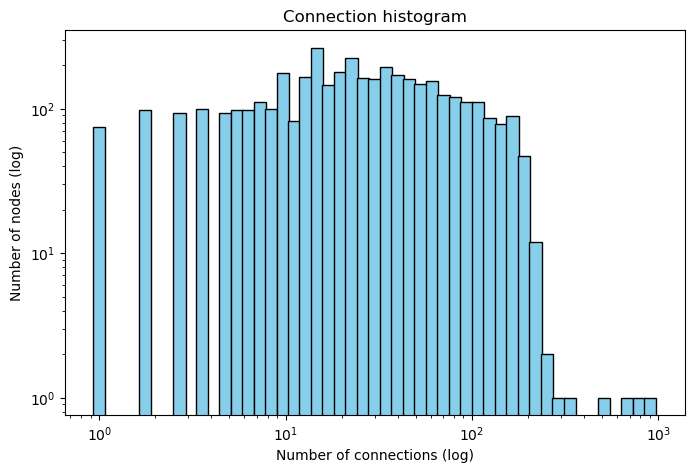

In [5]:
# applying log binning
degrees = [val for (node, val) in G.degree()]
degrees = np.array(degrees)
degrees = degrees[degrees > 0]
bins = np.logspace(np.log10(degrees.min()), np.log10(degrees.max()), 50)

plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=bins, color="skyblue", edgecolor="black", align="left")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of connections (log)")
plt.ylabel("Number of nodes (log)")
plt.title("Connection histogram")
plt.show()

# moreless uniform-like

#### Ex. 4

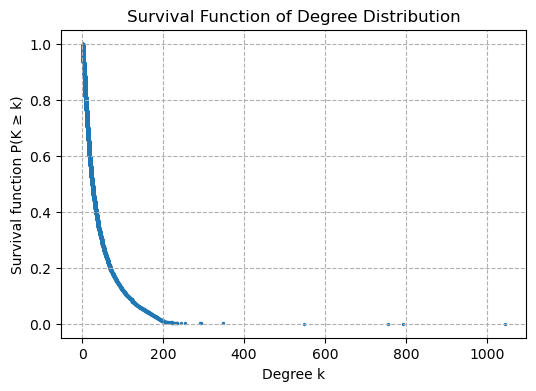

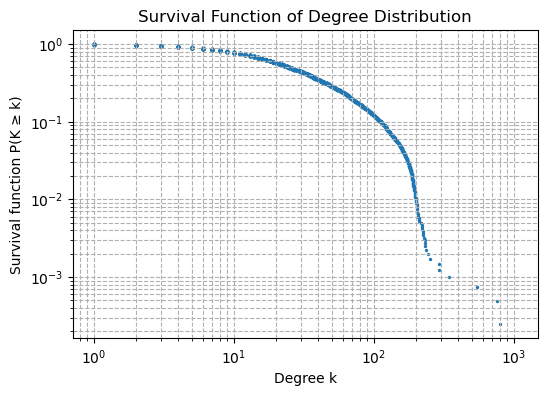

In [6]:
# survival function S(x) = 1 - F(x)

degrees = [val for (node, val) in G.degree()]

sorted_degrees = np.sort(degrees)
survival = 1.0 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)

plt.figure(figsize=(6, 4))
plt.scatter(sorted_degrees, survival, marker='o', s=2)
plt.xlabel("Degree k")
plt.ylabel("Survival function P(K ≥ k)")
plt.title("Survival Function of Degree Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(sorted_degrees, survival, marker='o', s=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k")
plt.ylabel("Survival function P(K ≥ k)")
plt.title("Survival Function of Degree Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

#### Ex. 5

In [7]:
# log-binned histogram (probably best, all the range of values at different scales is visible) and survival function are the most readable

#### Ex. 6

Estimated alpha: 2.140
R² = 0.852


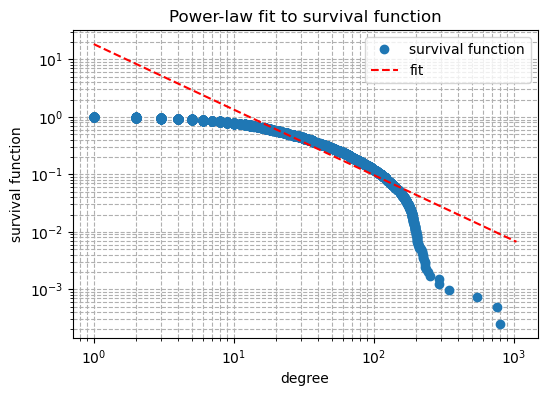

In [8]:
# determining alpha using linear regression

degrees = np.array([d for n, d in G.degree()])
sorted_degrees = np.sort(degrees)
survival = 1.0 - np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)

k_min = 10
mask = (sorted_degrees > k_min) & (survival > 0)
x = np.log10(sorted_degrees[mask])
y = np.log10(survival[mask])

slope, intercept, r_value, p_value, std_err = linregress(x, y)

alpha_est = 1 - slope  # slope = -(α - 1) for the CCDF
print(f"Estimated alpha: {alpha_est:.3f}")
print(f"R² = {r_value**2:.3f}")

# Plot with the regression line
plt.figure(figsize=(6,4))
plt.loglog(sorted_degrees, survival, 'o', label='survival function')
plt.loglog(sorted_degrees, 10**(intercept + slope * np.log10(sorted_degrees)), 'r--', label='fit')
plt.xlabel("degree")
plt.ylabel("survival function")
plt.title("Power-law fit to survival function")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

## Task 3

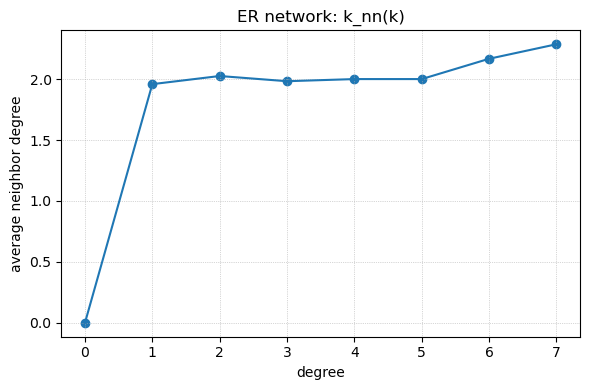

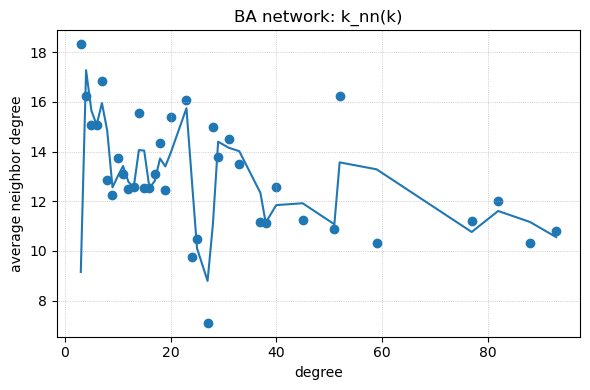

In [9]:
def compute_k_nn_by_k(G):
    and_vals = nx.average_neighbor_degree(G)
    deg = dict(G.degree())
    agg = defaultdict(list)
    for node, k in deg.items():
        agg[k].append(and_vals[node])
    rows = []
    for k in sorted(agg):
        vals = np.array(agg[k])
        rows.append((k, vals.mean(), vals.std(ddof=0), len(vals)))
    df = pd.DataFrame(rows, columns=['k','k_nn_mean','k_nn_std','count'])
    return df

n = 1000
p_er = 0.001
m_ba = 3 

G_er = nx.erdos_renyi_graph(n, p_er, seed=42)
G_ba = nx.barabasi_albert_graph(n, m_ba, seed=42)

df_er = compute_k_nn_by_k(G_er)
df_ba = compute_k_nn_by_k(G_ba)

def plot_knn(df, title):
    plt.figure(figsize=(6,4))
    plt.scatter(df['k'], df['k_nn_mean'])
    ks = df['k'].values
    knn = df['k_nn_mean'].values
    window = max(1, int(len(ks)*0.06))
    smooth = np.convolve(knn, np.ones(window)/window, mode='same')
    plt.plot(ks, smooth)
    plt.xlabel('degree')
    plt.ylabel('average neighbor degree')
    plt.title(title)
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_knn(df_er, "ER network: k_nn(k)")
plot_knn(df_ba, "BA network: k_nn(k)")

## Task 4

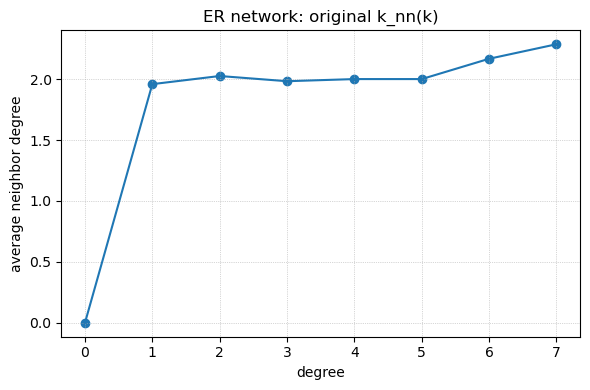

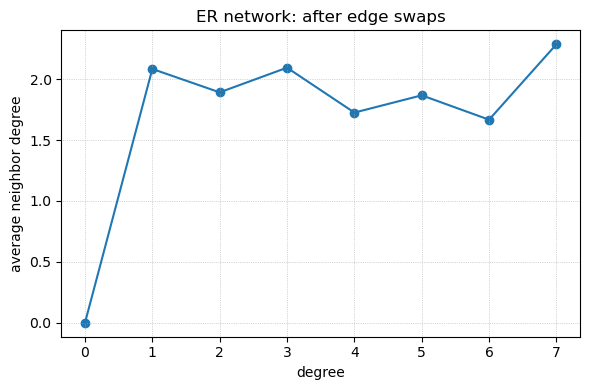

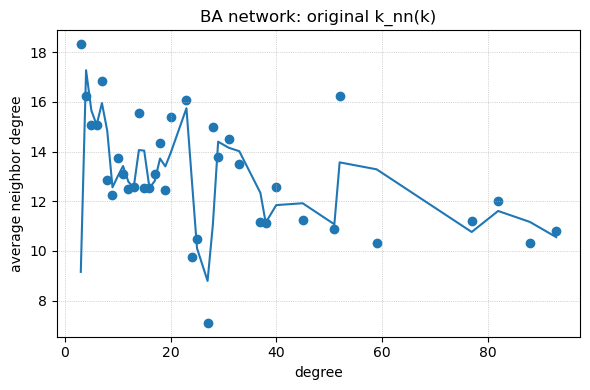

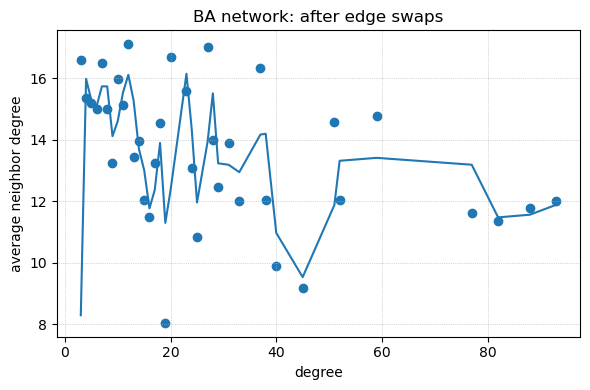

In [10]:
n = 1000
p_er = 0.001
m_ba = 3 
num_swaps = 10000

G_er = nx.erdos_renyi_graph(n, p_er, seed=42)
G_ba = nx.barabasi_albert_graph(n, m_ba, seed=42)

df_er = compute_k_nn_by_k(G_er)
df_ba = compute_k_nn_by_k(G_ba)

G_er_swapped = G_er.copy()
nx.double_edge_swap(G_er_swapped, nswap=num_swaps, max_tries=num_swaps*10)

G_ba_swapped = G_ba.copy()
nx.double_edge_swap(G_ba_swapped, nswap=num_swaps, max_tries=num_swaps*10)

df_er_swapped = compute_k_nn_by_k(G_er_swapped)
df_ba_swapped = compute_k_nn_by_k(G_ba_swapped)

plot_knn(df_er, "ER network: original k_nn(k)")
plot_knn(df_er_swapped, "ER network: after edge swaps")
plot_knn(df_ba, "BA network: original k_nn(k)")
plot_knn(df_ba_swapped, "BA network: after edge swaps")

# the results are similar

## Task 6

In [11]:
# correlation coef

def correlation_knn(G):
    deg = np.array([d for n, d in G.degree()])
    knn = np.array([nx.average_neighbor_degree(G)[n] for n in G.nodes()])
    r, _ = pearsonr(deg, knn)
    return r

r_er = correlation_knn(G_er)
r_er_swapped = correlation_knn(G_er_swapped)
r_ba = correlation_knn(G_ba)
r_ba_swapped = correlation_knn(G_ba_swapped)

print(f"ER network correlation: original={r_er:.3f}, swapped={r_er_swapped:.3f}")
print(f"BA network correlation: original={r_ba:.3f}, swapped={r_ba_swapped:.3f}")

ER network correlation: original=0.628, swapped=0.592
BA network correlation: original=-0.112, swapped=-0.063


In [12]:
# # optional
# def manual_assortativity(G):
#     deg = dict(G.degree())
#     rem = {n: max(0, d-1) for n, d in deg.items()}
#     M = G.number_of_edges()
#     if M == 0:
#         return np.nan
# 
#     counts = defaultdict(int)
#     for u, v in G.edges():
#         j = rem[u]; k = rem[v]
#         counts[(j, k)] += 1
#         counts[(k, j)] += 1
# 
#     total = 2 * M
#     ks = sorted({k for (k, _) in counts.keys()} | {k for (_, k) in counts.keys()})
#     e = {pair: cnt/total for pair, cnt in counts.items()}
# 
#     q = {j: sum(e.get((j, k), 0.0) for k in ks) for j in ks}
#     mean_q = sum(j * qj for j, qj in q.items())
#     mean_q2 = sum((j**2) * qj for j, qj in q.items())
#     sigma_q2 = mean_q2 - mean_q**2
#     if sigma_q2 == 0:
#         return 0.0
# 
#     num = 0.0
#     for j in ks:
#         for k in ks:
#             e_jk = e.get((j, k), 0.0)
#             num += j * k * (e_jk - q[j] * q[k])
#     r = num / sigma_q2
#     return r
# 
# def pearson_deg_knn_numpy(G):
#     deg_arr = np.array([d for n, d in G.degree()], dtype=float)
#     knn_dict = nx.average_neighbor_degree(G)
#     knn_arr = np.array([knn_dict[n] for n in G.nodes()], dtype=float)
#     mask = ~np.isnan(knn_arr)
#     if mask.sum() == 0 or np.std(deg_arr[mask]) == 0 or np.std(knn_arr[mask]) == 0:
#         return np.nan
#     r = np.corrcoef(deg_arr[mask], knn_arr[mask])[0,1]
#     return r
# 
# # n = 1000
# # G_er = nx.erdos_renyi_graph(n, p=0.001, seed=42)
# # G_ba = nx.barabasi_albert_graph(n, m=3, seed=42)
# # 
# # G_er_swapped = G_er.copy()
# # nx.double_edge_swap(G_er_swapped, nswap=10 * G_er.number_of_edges(), max_tries=100 * G_er.number_of_edges(), seed=1)
# # G_ba_swapped = G_ba.copy()
# # nx.double_edge_swap(G_ba_swapped, nswap=10 * G_ba.number_of_edges(), max_tries=100 * G_ba.number_of_edges(), seed=2)
# 
# for name, G in [("ER", G_er), ("ER_swapped", G_er_swapped), ("BA", G_ba), ("BA_swapped", G_ba_swapped)]:
#     r_manual = manual_assortativity(G)
#     r_nx = nx.degree_pearson_correlation_coefficient(G)
#     r_deg_knn = pearson_deg_knn_numpy(G)
#     print(f"{name}: manual_newman={r_manual:.4f}, networkx={r_nx:.4f}, pearson_deg_vs_knn={r_deg_knn:.4f}")


ER: manual_newman=0.0236, networkx=0.0236, pearson_deg_vs_knn=0.6279
ER_swapped: manual_newman=-0.0365, networkx=-0.0365, pearson_deg_vs_knn=0.5923
BA: manual_newman=-0.0757, networkx=-0.0757, pearson_deg_vs_knn=-0.1121
BA_swapped: manual_newman=-0.0548, networkx=-0.0548, pearson_deg_vs_knn=-0.0629


## Task 7

In [13]:
# def analyze_network(G, name="Unknown"):
#     """Compute key network statistics for any undirected graph G."""
#     # ensure graph is undirected and simple
#     if G.is_directed():
#         G = G.to_undirected()
#     G = nx.Graph(G)
#     
#     N = G.number_of_nodes()
#     E = G.number_of_edges()
#     avg_k = 2 * E / N if N > 0 else np.nan
#     
#     # degree list (exclude isolated nodes)
#     degrees = np.array([d for _, d in G.degree() if d > 0])
#     
#     # --- estimate power-law exponent alpha (simple log–log fit)
#     if len(degrees) > 0:
#         hist, bins = np.histogram(degrees, bins=range(1, degrees.max()+2))
#         valid = hist > 0
#         x = np.log(bins[:-1][valid])
#         y = np.log(hist[valid])
#         if len(x) > 1:
#             slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#             alpha = -slope  # P(k) ~ k^-α
#         else:
#             alpha = np.nan
#     else:
#         alpha = np.nan
#     
#     # --- average shortest path length
#     if nx.is_connected(G):
#         L = nx.average_shortest_path_length(G)
#     else:
#         largest_cc = max(nx.connected_components(G), key=len)
#         G_cc = G.subgraph(largest_cc)
#         L = nx.average_shortest_path_length(G_cc)
#     
#     # --- assortativity
#     r = nx.degree_pearson_correlation_coefficient(G)
#     
#     return {
#         "Network": name,
#         "N": N,
#         "E": E,
#         "<k>": round(avg_k, 3),
#         "α": round(alpha, 3),
#         "ℓ": round(L, 3),
#         "r": round(r, 3)
#     }



In [14]:
def load_graph(file_path):
    G = nx.Graph()
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue
            u, v = parts
            u, v = int(u), int(v)
            G.add_edge(u, v)
    return G

def approximate_average_shortest_path_length(G, sample_size=1000, seed=42):
    # approximated average shortest path length by sampling
    random.seed(seed)
    nodes = list(G.nodes())
    if len(nodes) == 0:
        return np.nan
    sample = random.sample(nodes, min(sample_size, len(nodes)))
    lengths = []
    for node in sample:
        # compute distances from this node
        sp = nx.single_source_shortest_path_length(G, node)
        # average distance to reachable nodes
        if len(sp) > 1:
            lengths.append(np.mean(list(sp.values())))
    return float(np.mean(lengths)) if lengths else np.nan

def analyze_network(G, name="Unknown", approximate=True, sample_size=1000):
    # obtaining undirected graph
    if G.is_directed():
        G = G.to_undirected()
    G = nx.Graph(G)
    
    N = G.number_of_nodes()
    E = G.number_of_edges()
    avg_k = 2 * E / N if N > 0 else np.nan

    # excluding isolated nodes
    degrees = np.array([d for _, d in G.degree() if d > 0])

    # alpha
    if len(degrees) > 1:
        hist, bins = np.histogram(degrees, bins=range(1, degrees.max() + 2))
        valid = hist > 0
        x = np.log(bins[:-1][valid])
        y = np.log(hist[valid])
        if len(x) > 1:
            slope, intercept, _, _, _ = stats.linregress(x, y)
            alpha = -slope  # P(k) ~ k^-alpha
        else:
            alpha = np.nan
    else:
        alpha = np.nan

    # average shortest path length l
    if approximate or N > 2000:
        L = approximate_average_shortest_path_length(G, sample_size=min(sample_size, N))
    else:
        if nx.is_connected(G):
            L = nx.average_shortest_path_length(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            G_cc = G.subgraph(largest_cc)
            L = nx.average_shortest_path_length(G_cc)

    # coefficient r
    r = nx.degree_pearson_correlation_coefficient(G)
    
    return {
        "Network": name,
        "N": N,
        "E": E,
        "<k>": round(avg_k, 3),
        "alpha": round(alpha, 3) if not np.isnan(alpha) else np.nan,
        "l": round(L, 3) if not np.isnan(L) else np.nan,
        "r": round(r, 3) if not np.isnan(r) else np.nan
    }

In [15]:
# https://cs.stanford.edu/people/jure/pubs/thesis/jure-thesis.pdf
# https://snap.stanford.edu/data/

# DELICIOUS
# EPINIONS
# CIT-HEP-PH
# CA-ASTRO-PH
# POWERGRID

files = ["input/soc-delicious.mtx", "input/soc-Epinions1.txt", "input/Cit-HepPh.txt", "input/CA-AstroPh.txt", "input/power-US-Grid.mtx"]
names = ["DELICIOUS", "EPINIONS", "CIT-HEP-PH", "CA-ASTRO-PH", "POWERGRID"]
results = []

In [16]:
idx = 0
G = load_graph(files[idx])
results.append(analyze_network(G, names[idx]))

In [17]:
idx = 1
G = load_graph(files[idx])
results.append(analyze_network(G, names[idx]))

In [18]:
idx = 2
G = load_graph(files[idx])
results.append(analyze_network(G, names[idx]))

In [19]:
idx = 3
G = load_graph(files[idx])
results.append(analyze_network(G, names[idx]))

In [20]:
idx = 4
G = load_graph(files[idx])
results.append(analyze_network(G, names[idx]))

In [21]:
# total results
df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv("output/results.csv", index=False)

       Network       N        E     <k>  alpha       l      r
0    DELICIOUS  536108  1365961   5.096  1.864   5.499 -0.069
1     EPINIONS   75879   405740  10.694  1.593   4.327 -0.041
2   CIT-HEP-PH   34546   420921  24.369  2.054   4.318 -0.006
3  CA-ASTRO-PH   18772   198110  21.107  1.843   4.074  0.205
4    POWERGRID    4941     6594   2.669  2.845  19.159  0.003


In [24]:
# values provided in
# https://cs.stanford.edu/people/jure/pubs/thesis/jure-thesis.pdf

data = {
    "Network": ["DELICIOUS", "EPINIONS", "CIT-HEP-PH", "CA-ASTRO-PH", "POWERGRID"],
    "N": [147_567, 75_877, 34_401, 17_903, 4_941],
    "E": [301_921, 405_739, 420_784, 196_972, 6_594],
    "⟨k⟩": [4.09, 10.69, 24.46, 22.00, 2.67],
    "alpha": [None, None, None, None, None],
    "l": [6.28, 4.27, 4.33, 4.21, 19.07],
    "r": [None, None, None, None, None]
}

networks_df = pd.DataFrame(data)

print(networks_df)

       Network       N       E    ⟨k⟩ alpha      l     r
0    DELICIOUS  147567  301921   4.09  None   6.28  None
1     EPINIONS   75877  405739  10.69  None   4.27  None
2   CIT-HEP-PH   34401  420784  24.46  None   4.33  None
3  CA-ASTRO-PH   17903  196972  22.00  None   4.21  None
4    POWERGRID    4941    6594   2.67  None  19.07  None


## Task 8

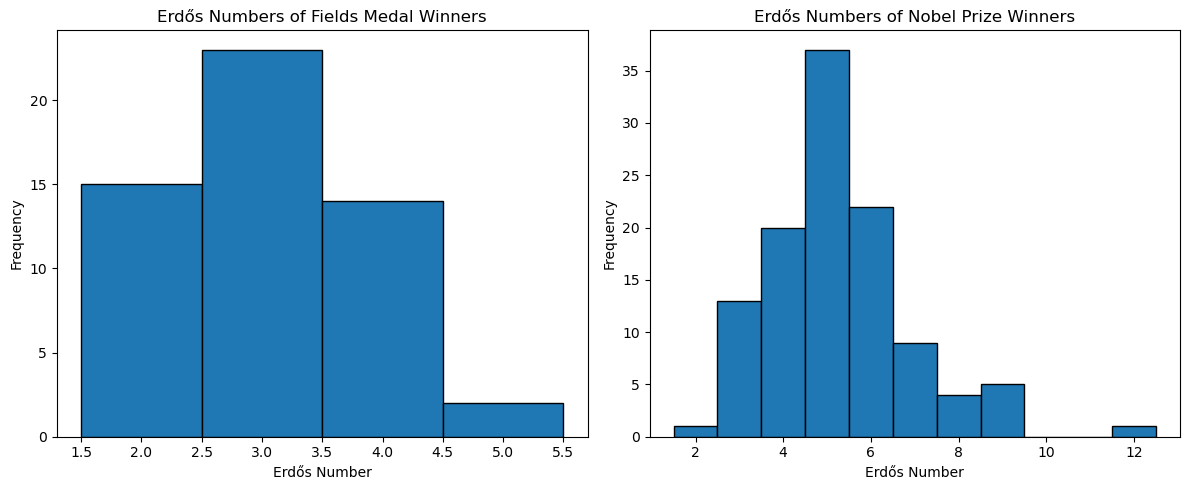

In [23]:
# https://sites.google.com/oakland.edu/grossman/home/the-erdoes-number-project/some-famous-people-with-finite-erdoes-numbers/fields-medal-winners
# https://sites.google.com/oakland.edu/grossman/home/the-erdoes-number-project/some-famous-people-with-finite-erdoes-numbers/nobel-prize-winners


# Fields Medal data Erdős numbers
fields_erdos = [
    4,4,4,2,2,2,2,4,3,3,4,5,5,4,2,4,3,3,2,2,3,2,3,3,3,2,2,4,3,2,3,4,4,3,3,4,3,2,4,3,3,3,3,3,2,4,3,4,3,3,2,3,2,3
]

# Nobel Prize data Erdős numbers
nobel_erdos = [
    5,8,7,4,4,7,6,2,4,4,5,4,4,4,5,3,6,3,3,4,3,5,4,5,5,6,5,5,5,4,9,7,7,8,9,5,5,4,6,5,5,6,5,5,6,5,6,7,8,6,6,5,5,6,3,3,7,9,12,9,5,7,8,5,5,9,6,6,5,5,6,3,3,7,4,4,3,3,5,5,3,5,6,4,3,6,6,4,6,6,5,5,6,5,5,3,4,5,4,7,5,4,5,4,5,6,6,5,6,4,5,5
]

# Draw histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(fields_erdos, bins=range(2, 7), edgecolor='black', align='left')
plt.title("Erdős Numbers of Fields Medal Winners")
plt.xlabel("Erdős Number")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(nobel_erdos, bins=range(2, 14), edgecolor='black', align='left')
plt.title("Erdős Numbers of Nobel Prize Winners")
plt.xlabel("Erdős Number")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()